In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# ----------------------------
# Load and Clean NGL Data
# ----------------------------

# File path
ngl_filepath = '/Users/markbogorad/Desktop/NYU_MFE/Semester_2/1.2_Trading_Energy_Derivatives_MATH_GA_2800/Oil_Project/Systematic_Energy_Trading/Data/NGLs.xlsx'

# Load the data
ngl_datasets = load_ngl_data(ngl_filepath)

def load_ngl_data(filepath):
    xl = pd.ExcelFile(filepath)
    sheets = xl.sheet_names
    print(f"Available Sheets: {sheets}")
    
    ngl_data = {}
    for sheet in sheets:
        df = xl.parse(sheet, header=4)  # Start from row 5 (header=4)
        df = df.rename(columns={df.columns[0]: 'Date'})  # Rename the date column
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert date column
        df = df.dropna(subset=['Date'])  # Drop rows where date is NaT

        # Dynamically rename columns based on the commodity prefix
        df.columns = ['Date'] + [f"{sheet}{i+1} Comdty" for i in range(len(df.columns)-1)]

        ngl_data[sheet] = df
    
    return ngl_data

# Load the data
ngl_datasets = load_ngl_data(ngl_filepath)

# Display one of the datasets to verify
for key, df in ngl_datasets.items():
    print(f"\nFirst few rows of sheet: {key}")
    print(df.head())
    break  # Display only the first sheet for now




Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']
Available Sheets: ['NG', 'CAP', 'BAP', 'DAE', 'IBD', 'MMB', 'PCW', 'PGP']

First few rows of sheet: NG
        Date  NG1 Comdty  NG2 Comdty  NG3 Comdty  NG4 Comdty  NG5 Comdty  \
0 2011-07-07       4.133       4.138       4.168       4.324       4.535   
1 2011-07-08       4.205       4.204       4.231       4.385       4.600   
2 2011-07-11       4.288       4.277       4.302       4.447       4.656   
3 2011-07-12       4.333       4.312       4.335       4.473       4.675   
4 2011-07-13       4.403       4.387       4.411       4.540       4.737   

   NG6 Comdty  NG7 Comdty  NG8 Comdty  NG9 Comdty  ...  NG15 Comdty  \
0       4.642       4.644       4.608       4.525  ...        4.706   
1       4.709       4.710       4.673       4.586  ...        4.769   
2       4.764       4.765       4.728       4.642  ...        4.824   
3       4.783       4.782       4.741       4.654  ...        4.834   
4       4.8

In [16]:
def carry_strategy(df, commodity_prefix, epsilon=0):
    """Apply the carry strategy for a single commodity dataframe."""
    front_contract = f'{commodity_prefix}1 Comdty'
    back_contract = f'{commodity_prefix}2 Comdty'
    
    # Check if contracts exist
    if front_contract not in df.columns or back_contract not in df.columns:
        print(f"Skipping {commodity_prefix}: Missing contracts.")
        return None
    
    # Calculate the carry spread and generate signals
    df['Spread'] = df[front_contract] - df[back_contract]
    df['Signal'] = np.where(df['Spread'] > epsilon, 1, np.where(df['Spread'] < -epsilon, -1, 0))
    
    # Calculate daily returns based on signals
    df['Returns'] = df[front_contract].pct_change().shift(-1) * df['Signal']
    df['Equity'] = (1 + df['Returns']).cumprod()

    return df[['Date', 'Equity']]

carry_results = {}


for commodity, df in ngl_datasets.items():
    result = carry_strategy(df, commodity_prefix=commodity, epsilon=0.05)
    if result is not None:
        carry_results[commodity] = result



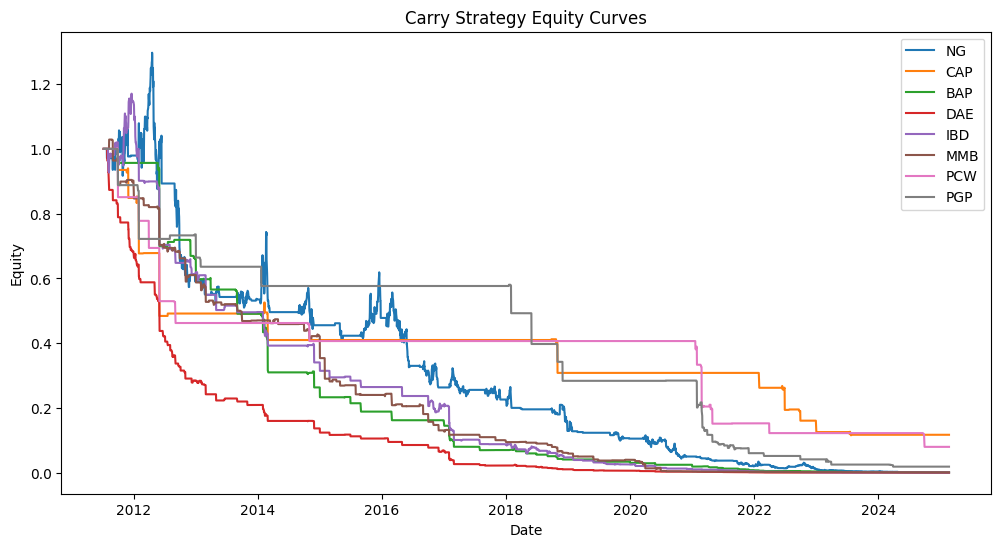

In [17]:
def plot_carry_equity(results):
    plt.figure(figsize=(12, 6))
    for commodity, result_df in results.items():
        plt.plot(result_df['Date'], result_df['Equity'], label=commodity)
    plt.legend()
    plt.title("Carry Strategy Equity Curves")
    plt.xlabel("Date")
    plt.ylabel("Equity")
    plt.show()

plot_carry_equity(carry_results)


In [ ]:
def compute_metrics(df, pnl_column):
    annual_pnl = df[pnl_column].sum() / (len(df) / 252)  # Annualized P&L
    sharpe_ratio = annual_pnl / (df[pnl_column].std() * np.sqrt(252))
    
    hwm = df[pnl_column].cummax()
    max_drawdown = (hwm - df[pnl_column]).max()
    return_on_drawdown = annual_pnl / max_drawdown if max_drawdown != 0 else np.nan
    
    return {
        "Annual PnL": annual_pnl,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Return on Drawdown": return_on_drawdown
    }
